In [199]:
import os
import math
import random
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt

# CREATE PANDAS DATAFRAME FOR PREPROCESSING

In [200]:
# Define column names
columns = ['path_to_file', 'voice_author', 'target_class', 'sample_rate']
# Create an empty DataFrame
df = pd.DataFrame(columns=columns)
# Display the empty DataFrame
print(df)

Empty DataFrame
Columns: [path_to_file, voice_author, target_class, sample_rate]
Index: []


In [201]:
# Data preprocessing
VOICES_PATH = "data/voices"

target_class = 0
for folder in os.listdir(VOICES_PATH):
    for filename in os.listdir(os.path.join(VOICES_PATH, folder)):
        path_to_file = os.path.join(VOICES_PATH, folder, filename)
        voice_author = folder
        y, sr = librosa.load(path_to_file)
        new_row = {
            'path_to_file': path_to_file, 
            'voice_author': voice_author, 
            'target_class': target_class, 
            'sample_rate': sr, 
            'len_of_': len(y)
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    target_class += 1

In [202]:
pd.concat([df.head(), df.iloc[4000:4005,:], df.tail()])

,path_to_file,voice_author,target_class,sample_rate,len_of_
0,data/voices/Jens_Stoltenberg/1078.wav,Jens_Stoltenberg,0,22050,22050.0
1,data/voices/Jens_Stoltenberg/1044.wav,Jens_Stoltenberg,0,22050,22050.0
2,data/voices/Jens_Stoltenberg/1050.wav,Jens_Stoltenberg,0,22050,22050.0
3,data/voices/Jens_Stoltenberg/249.wav,Jens_Stoltenberg,0,22050,22050.0
4,data/voices/Jens_Stoltenberg/275.wav,Jens_Stoltenberg,0,22050,22050.0
4000,data/voices/Julia_Gillard/608.wav,Julia_Gillard,2,22050,22050.0
4001,data/voices/Julia_Gillard/90.wav,Julia_Gillard,2,22050,22050.0
4002,data/voices/Julia_Gillard/146.wav,Julia_Gillard,2,22050,22050.0
4003,data/voices/Julia_Gillard/620.wav,Julia_Gillard,2,22050,22050.0
4004,data/voices/Julia_Gillard/634.wav,Julia_Gillard,2,22050,22050.0


# VISUALIZATION OF POTENTIAL FEATURES

/var/folders/0_/nzr6zwms0wnbk944qwmv4bf40000gn/T/ipykernel_73827/3284499356.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


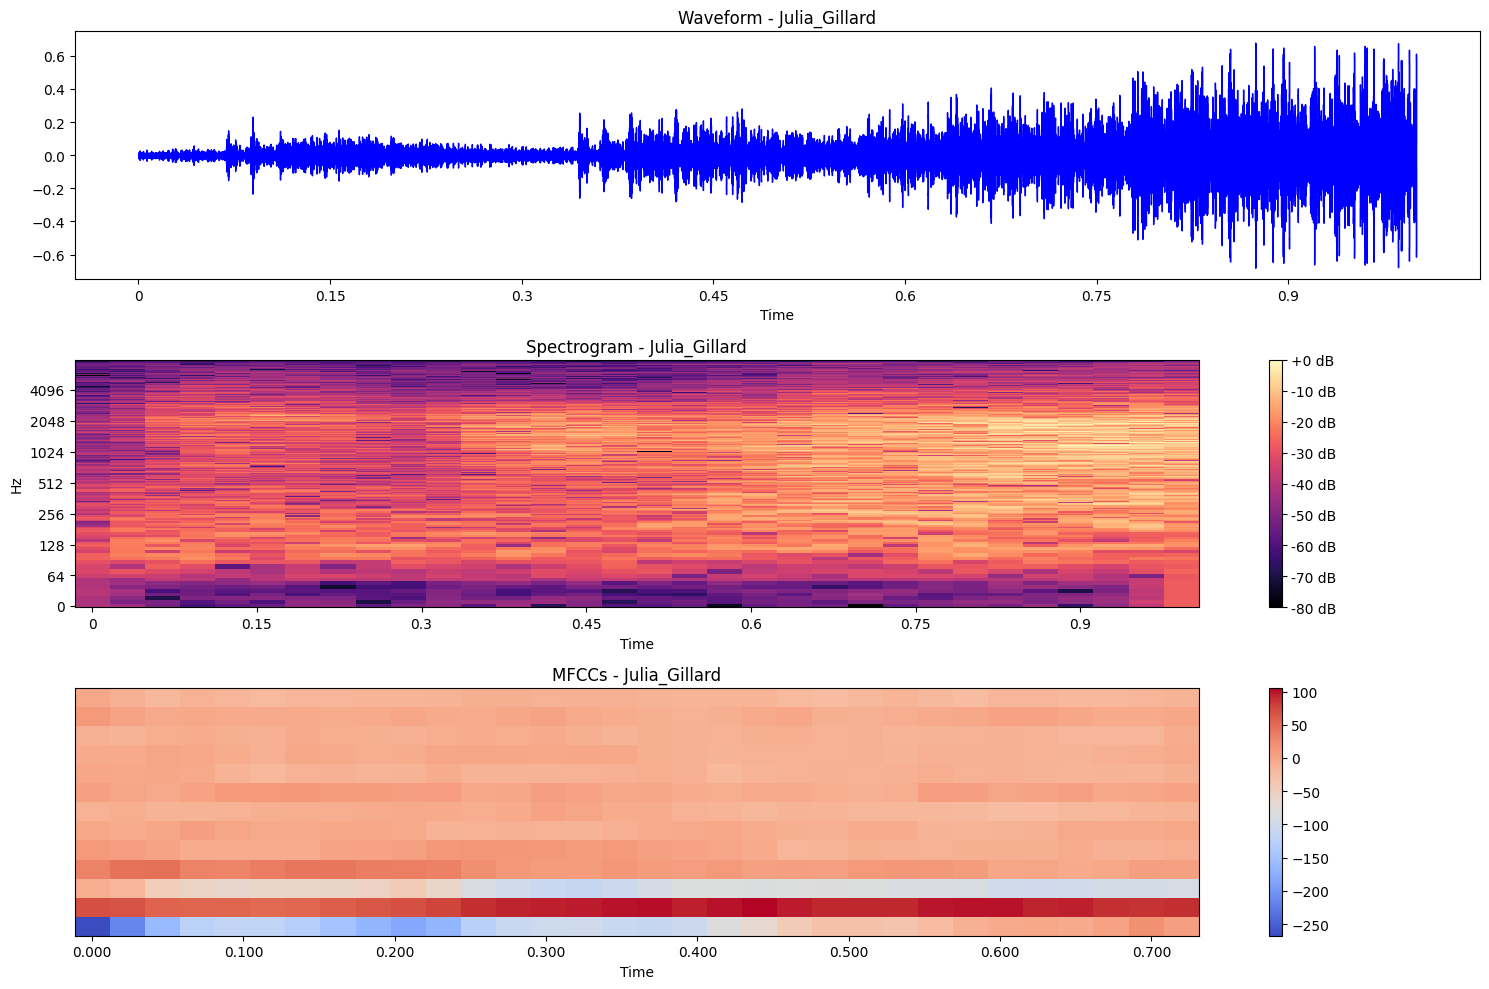

In [203]:
# Function to plot the waveform, spectrogram, and MFCCs
def plot_audio_features(audio_path, speaker_name):
    # Load file
    y, sr = librosa.load(audio_path, sr=None)

    # Plot the waveform
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr, color="blue")
    plt.title(f'Waveform - {speaker_name}')

    # Plot the spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {speaker_name}')

    # Plot the MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCCs - {speaker_name}')

    plt.tight_layout()
    plt.show()


plot_audio_features(
    df.iloc[random.randint(0, len(df))].iloc[0],
    df.iloc[random.randint(0, len(df))].iloc[1])

# MODEL

In [204]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [205]:
# Set the data directory for voices folders
parent_dir = "./data/voices"

# List of speaker folders
speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]
def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)
        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

In [206]:
X[0].shape

(32, 13)

In [207]:
print(tf.config.list_physical_devices('GPU'))

[]


In [208]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela",
    "UNKNOWN"
]

# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Training Data Shape:", X_test.shape)

[0 0 0 ... 4 4 4]
[0 0 0 ... 4 4 4]
Training Data Shape: (5250, 32, 13)
Validation Data Shape: (1125, 32, 13)
Training Data Shape: (1126, 32, 13)


In [211]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

/Users/adamerik/Documents/code/python/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [212]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,350 (317.77 KB)

 Trainable params: 81,350 (317.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6968 - loss: 0.8358 - val_accuracy: 0.9333 - val_loss: 0.1773
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9333 - loss: 0.1857 - val_accuracy: 0.9404 - val_loss: 0.1447
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9333 - loss: 0.1735 - val_accuracy: 0.9636 - val_loss: 0.1250
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9684 - loss: 0.1070 - val_accuracy: 0.9751 - val_loss: 0.0709
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9699 - loss: 0.0925 - val_accuracy: 0.9742 - val_loss: 0.0761
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9685 - loss: 0.0956 - val_accuracy: 0.9716 - val_loss: 0.0835
Early stopping triggered at epoch 6


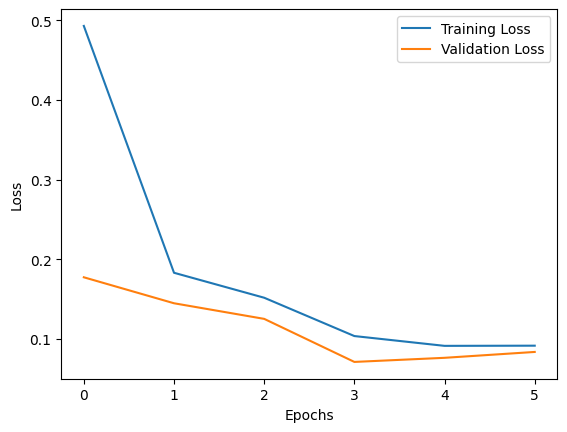

In [213]:

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Evaluation Accuracy: 0.9706927175843695
Weighted F1 Score: 0.9706535757545086


/Users/adamerik/Documents/code/python/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


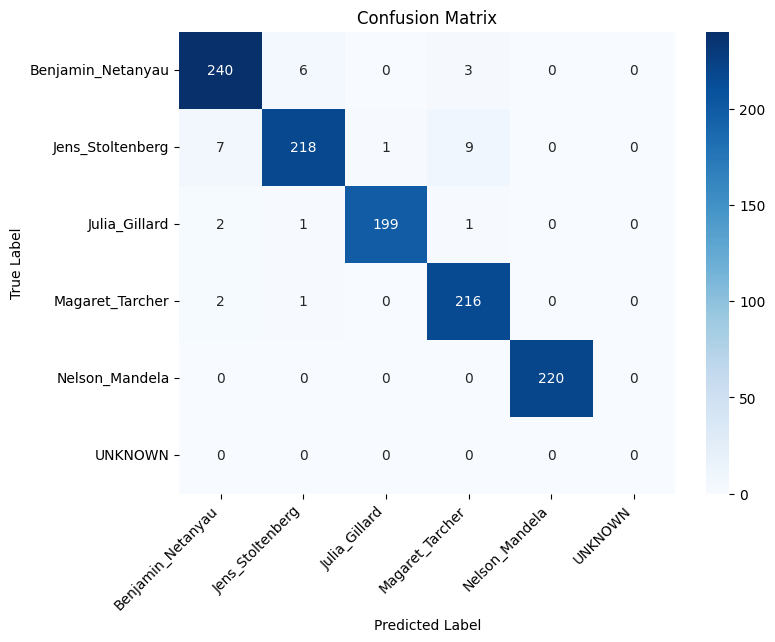

In [214]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()